In [1]:
import cartopy
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from pyproj import Transformer
from geopy.geocoders import GoogleV3 

In [2]:
column_names = {
    "Region": "region", "State": "state", "Sector": "sector", "Station Type": "station_type", 
    "Station": "station", "Unit": "unit", "Date": "date", "Outage Type": "outage_type", 
    "Monitored CAP in MW": "monitored_capacity", "Generation / Today's Program": "generation_target", 
    "Generation / Today's Actual": "generation_achieved", "Generation / FY YTD Program": "generation_ytd_target", 
    "Generation / FY YTD Actual": "generation_ytd_achieved", "Coal Stock in Days": "coal_stock", 
    "CAP under outage": "outage_capacity", "Outage Date": "outage_date", "Expected Date / Sync Date": "expected_date",
    "Remarks": "outage_remarks"
} 

locator = GoogleV3("--enter-google-maps-api-key--")
def get_location(row: pd.Series) -> tuple[float, float]: 
    station_name: str = row["station"]
    if " ccpp" in station_name:
        station_name = station_name.replace("ccpp", "combined cycle power project")
    elif " stpp" in station_name:
        station_name = station_name.replace("stpp", "super thermal power project")
    elif " stps" in station_name:
        station_name = station_name.replace("stps", "super thermal power station")
    elif " tps" in station_name:
        station_name = station_name.replace("tps", "thermal power station")
    elif " tpp" in station_name:
        station_name = station_name.replace("tpp", "thermal power plant")

    location = locator.geocode((station_name + f", {row["state"]}").title())
    if location is not None:
        return location.latitude, location.longitude
    else:
        return np.nan, np.nan
    
to_web_mercator = Transformer.from_crs("EPSG:4326", "EPSG:3857")

unit_df = (
    pd.read_csv(Path.cwd() / "data" / "unit.csv")
    .rename(columns=column_names)
    .drop(columns=["generation_ytd_achieved", "generation_ytd_target", "coal_stock", "expected_date"])
    .assign(region=lambda df: df["region"].str.lower().astype("string"))
    .assign(state=lambda df: df["state"].str.lower().astype("string"))
    .assign(sector=lambda df: df["sector"].str.lower().astype("string"))
    .assign(station_type=lambda df: df["station_type"].str.lower().astype("string"))
    .assign(station=lambda df: df["station"].str.lower().astype("string"))
    .assign(unit=lambda df: df["unit"].str.removeprefix("Unit ").astype(int))
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .assign(outage_date=lambda df: pd.to_datetime(df["outage_date"]))
    .assign(outage_remarks=lambda df: df["outage_remarks"].str.lower().astype("string"))
)
last_date = unit_df["date"].max()

station_locations_df = (
    pd.read_csv("data/station_locations.csv", index_col=0)
    .assign(latitude = lambda df: df["0"].apply(lambda x: x.split(",")[0].removeprefix("(")))
    .assign(longitude = lambda df: df["0"].apply(lambda x: x.split(",")[1].removesuffix(")")))
    .drop(columns="0")
)

stations_df = pd.concat([
    (
        unit_df
        .groupby(["station", "station_type", "sector", "state", "region", "unit"]).agg({"monitored_capacity": "max", "outage_type": "count", "date": "min"}).reset_index()
        .groupby(["station", "station_type", "sector", "state", "region"]).agg({"unit": "count", "monitored_capacity": "sum", "outage_type": "sum", "date": "min"})
        .rename(columns={"unit": "units", "outage_type": "outages"})
        .assign(outages_per_month = lambda df: df.apply(lambda row: row["outages"] / ((last_date-row["date"]).days / 30), axis = 1))
        .reset_index()
    ), 
    station_locations_df
], axis=1)

stations_df[["latitude_web", "longitude_web"]] = stations_df.apply(lambda row: to_web_mercator.transform(row["latitude"], row["longitude"]), axis = 1, result_type="expand")

stations = stations_df["station"].to_list()
unit_df = (
    unit_df
    .assign(station = lambda df: df["station"].apply(lambda s: stations.index(s)))
    .drop(columns=["region", "state", "sector", "station_type", "monitored_capacity"])
)
outage_df = (
    unit_df[unit_df["outage_type"].notna()]
    .copy(deep=True)
)
generation_df = (
    unit_df[unit_df["outage_type"].isna()]
    .drop(columns=["outage_type", "outage_capacity", "outage_date", "outage_remarks"])
)

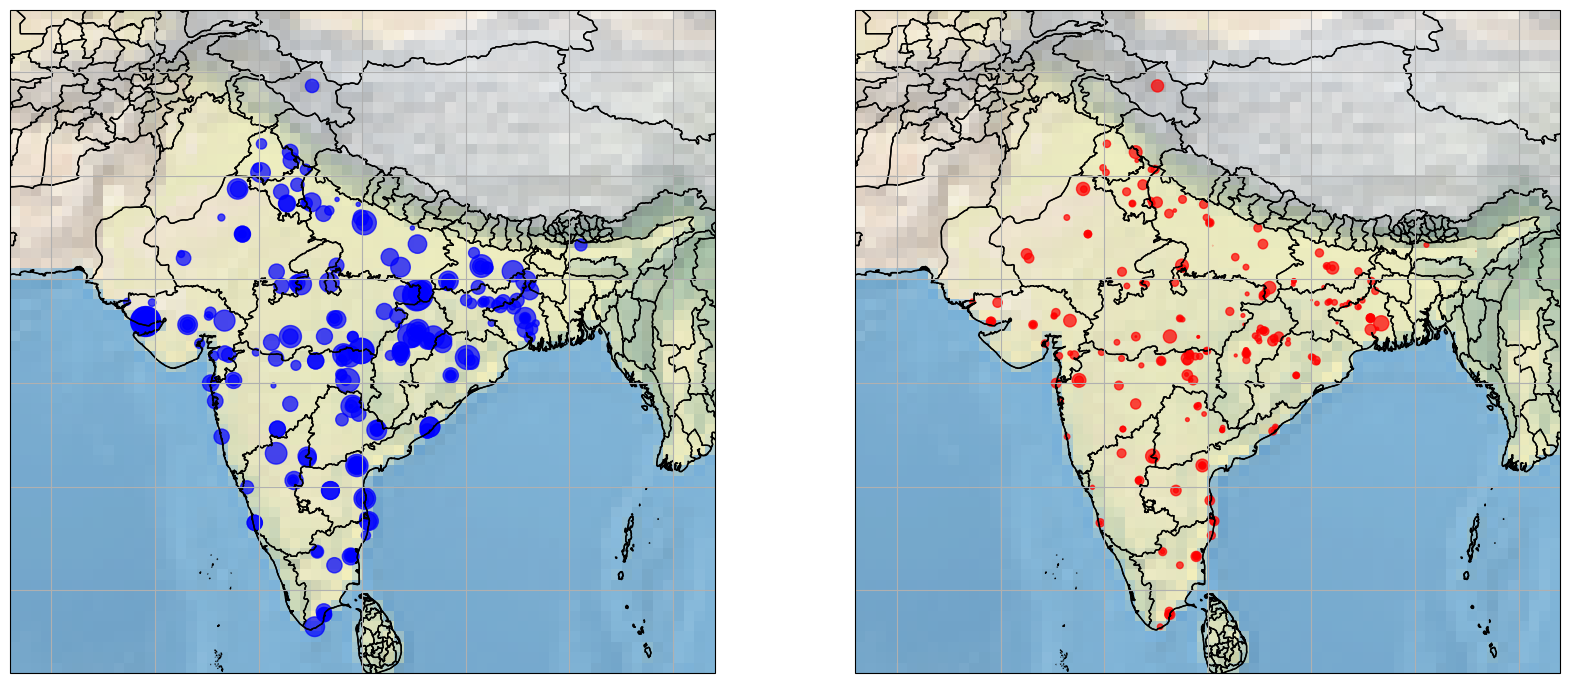

In [3]:
fig = plt.figure(figsize=(20, 10))
ax0 = fig.add_subplot(121, projection = cartopy.crs.PlateCarree())
ax0.stock_img()
ax0.coastlines()
ax0.gridlines()
ax0.set_extent([63, 97, 6, 38], crs = cartopy.crs.PlateCarree())
ax0.add_feature(cartopy.feature.STATES.with_scale('10m'))
ax0.scatter(x = stations_df["latitude_web"], y = stations_df["longitude_web"], s = stations_df["monitored_capacity"] / 10, transform = cartopy.crs.Mercator(), alpha = .7, color = "blue")

ax1 = fig.add_subplot(122, projection = cartopy.crs.PlateCarree())
ax1.stock_img()
ax1.coastlines()
ax1.gridlines()
ax1.set_extent([63, 97, 6, 38], crs = cartopy.crs.PlateCarree())
ax1.add_feature(cartopy.feature.STATES.with_scale('10m'))
ax1.scatter(x = stations_df["latitude_web"], y = stations_df["longitude_web"], s = stations_df["outages_per_month"], transform = cartopy.crs.Mercator(), alpha = .7, color = "red")

plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15, 5))
df = generation_df[generation_df["station"] == 261].groupby(["station", "date"]).sum()
df = df.drop(columns="unit").reset_index()
df
ax.plot(df["date"], df["generation_target"])
ax.plot(df["date"], df["generation_achieved"])

In [ ]:
# Thermal Power Plant
# Combined Cycle Power Plant
# Super Thermal Power Project

# > Bubblemap using locations and avg generation per year
# > Scatter Plots Showing Programmed vs Actual Power Generation, w/ x=y graph
# > Bubblemap using locations and number of outages per sate, outages per sector, reasons for outages, timeline for outages